In [187]:
import os

import cv2
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor, load, save
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import MultiLabelBinarizer
import torchvision

import matplotlib.pyplot as plt

import numpy as np

In [188]:
DATASET_DIR = "../../data/nutrition5k_dataset_nosides/"
PROCESSED_DIR = os.path.join(DATASET_DIR, "processed")

IMG_DIR = "../../data/nutrition5k_dataset_nosides/imagery/realsense_overhead/"

INGREDIENTS_PATH = os.path.join(PROCESSED_DIR, "ingredients_metadata.csv")
DISHES_PATH = os.path.join(PROCESSED_DIR, "dishes_info.csv")

In [189]:
def find_empty_directories(directory):
    empty_dirs = []
    
    for dirpath, dirnames, files in os.walk(directory):
        if not dirnames and not files:
            empty_dirs.append(dirpath.split("/")[-1])
    
    return empty_dirs

# Usage:
empty_folder_names = find_empty_directories(IMG_DIR)
print(empty_folder_names)

['dish_1558109714', 'dish_1558109511', 'dish_1557862384']


In [190]:
def check(str, empty_folder_names):
    print(str)
    return str in empty_folder_names

In [191]:
df = pd.read_csv(DISHES_PATH)
print(len(df["dish_id"].index))

print(len(df[~df["dish_id"].isin(empty_folder_names)].index))


3493
3490


In [192]:
df = pd.read_csv(INGREDIENTS_PATH)
labels = df["ingredient_id"]

label_binarizer = MultiLabelBinarizer()
label_binarizer.fit([labels.to_list()])

num_of_classes = label_binarizer.classes_.shape[0]
print("number of classes:", num_of_classes)
# label_binarizer.transform([[2, 3]])[0]

number of classes: 247


In [193]:
class IngredientDataset(Dataset):
    def __init__(self, img_dir: str, ingredients_path: str, dish_info_path: str, transform=None, ignore_dish_ids=[]):
        self.img_dir = img_dir

        self.ing_df = pd.read_csv(ingredients_path)
        self.dish_info_df = pd.read_csv(dish_info_path)

        self.ing_df = self.ing_df[~self.ing_df["dish_id"].isin(empty_folder_names)]
        self.dish_info_df = self.dish_info_df[~self.dish_info_df["dish_id"].isin(empty_folder_names)]

        self.transform = transform

        self.label_binarizer = MultiLabelBinarizer()
        self.label_binarizer.fit([self.ing_df["ingredient_id"].to_list()])

    def __len__(self) -> int:
        return len(self.dish_info_df)

    def __getitem__(self, index):
        dish = self.dish_info_df.iloc[index]
        dish_id = dish[0]
        # print(dish_id)

        ingredient_ids = self.ing_df[self.ing_df["dish_id"] == dish_id]["ingredient_id"].values
        label_encoded = self.label_binarizer.transform([ingredient_ids])[0]
        label_tensor = torch.FloatTensor(label_encoded)
        # print(ingredient_ids)

        dish_weight = dish[2]
        # print(dish_weight)
        weight_in_g_tensor = torch.FloatTensor([dish_weight])

        img_path = os.path.join(self.img_dir, dish_id, "rgb.png")
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = np.transpose(img, (2, 0, 1))
        # plt.imshow(img)
        # plt.show()

        img_tensor = torch.FloatTensor(img)
        img_tensor = self.transform(img_tensor) if self.transform is not None else img_tensor

        return img_tensor, label_tensor, weight_in_g_tensor

    def get_num_of_classes(self) -> int:
        return self.label_binarizer.classes_.shape[0]

In [194]:
def get_accuracy(y_pred: Tensor, y_train: Tensor) -> float:
    y_pred_index = torch.argmax(y_pred, 1)
    y_train_index = torch.argmax(y_train, 1)
    return (y_pred_index == y_train_index).sum().item() / y_pred.shape[0]

In [195]:
def print_statistics(epoch: int, batch: int, num_batches: int, loss: float, acc: float):
    print(f"EPOCH {epoch + 1} | BATCH {batch + 1} of {num_batches} | LOSS {loss:.4f} | ACCURACY {acc:.4f}")

In [196]:
def average_chunkwise(list, size: int, num_epochs: int):
    return [sum(list[i * size: (i + 1) * size]) / size for i in range(num_epochs)]

In [197]:
dataset = IngredientDataset(img_dir=IMG_DIR, ingredients_path=INGREDIENTS_PATH, dish_info_path=DISHES_PATH)

training_dataset, validation_dataset = random_split(dataset, [0.7, 0.3])

training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [198]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

num_classes = dataset.get_num_of_classes()
model = torchvision.models.mobilenet_v3_small(pretrained=True)

num_ftrs = model.classifier[3].in_features

# Change the output layer to match the custom number of classes
model.classifier[3] = torch.nn.Linear(num_ftrs, num_classes)

/Users/maxburzer/Desktop/SnackTrack-Backend/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maxburzer/Desktop/SnackTrack-Backend/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [199]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# collect stats
train_loss = []
train_acc = []
val_acc = []

In [200]:
device = "cpu"

In [132]:
num_epochs = 1

for epoch in range(num_epochs):
    
    model.train()
    torch.enable_grad()
    print("TRAINING...")

    for index, (X_train, y_train, y_w_train) in enumerate(training_dataloader):
        # move to GPU
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # forward
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        acc = get_accuracy(y_pred, y_train)

        # collect stats
        train_loss.append(loss.item())
        train_acc.append(acc)
        print_statistics(epoch, index, len(training_dataloader), loss.item(), acc)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    torch.no_grad()
    print("TESTING...")

    for index, (X_val, y_val, y_w_train) in enumerate(validation_dataloader):
        # move to GPU
        X_val = X_val.to(device)
        y_val = y_val.to(device)

        # forward
        y_pred = model(X_val)
        acc = get_accuracy(y_pred, y_val)

        # collect stats
        val_acc.append(acc)
        print_statistics(epoch, index, len(validation_dataloader), 0, acc)

TRAINING...


/var/folders/18/mk89nqqd4t1738cgptywpmw00000gn/T/ipykernel_11965/3049931474.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dish_id = dish[0]
/var/folders/18/mk89nqqd4t1738cgptywpmw00000gn/T/ipykernel_11965/3049931474.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dish_weight = dish[2]


EPOCH 1 | BATCH 1 of 77 | LOSS 42.2609 | ACCURACY 0.0000
EPOCH 1 | BATCH 2 of 77 | LOSS 41.0384 | ACCURACY 0.0000
EPOCH 1 | BATCH 3 of 77 | LOSS 36.2374 | ACCURACY 0.0000
EPOCH 1 | BATCH 4 of 77 | LOSS 26.5163 | ACCURACY 0.0000
EPOCH 1 | BATCH 5 of 77 | LOSS 31.0796 | ACCURACY 0.0000
EPOCH 1 | BATCH 6 of 77 | LOSS 39.2444 | ACCURACY 0.0000
EPOCH 1 | BATCH 7 of 77 | LOSS 43.7469 | ACCURACY 0.0000
EPOCH 1 | BATCH 8 of 77 | LOSS 33.9219 | ACCURACY 0.0000
EPOCH 1 | BATCH 9 of 77 | LOSS 26.2179 | ACCURACY 0.0312
EPOCH 1 | BATCH 10 of 77 | LOSS 28.8485 | ACCURACY 0.0000
EPOCH 1 | BATCH 11 of 77 | LOSS 31.3739 | ACCURACY 0.0000
EPOCH 1 | BATCH 12 of 77 | LOSS 35.1429 | ACCURACY 0.0312
EPOCH 1 | BATCH 13 of 77 | LOSS 22.0125 | ACCURACY 0.0000
EPOCH 1 | BATCH 14 of 77 | LOSS 32.1843 | ACCURACY 0.0312
EPOCH 1 | BATCH 15 of 77 | LOSS 35.5405 | ACCURACY 0.0312
EPOCH 1 | BATCH 16 of 77 | LOSS 33.5846 | ACCURACY 0.0000
EPOCH 1 | BATCH 17 of 77 | LOSS 38.5215 | ACCURACY 0.0000
EPOCH 1 | BATCH 18 of 7

[ WARN:0@2053.173] global loadsave.cpp:248 findDecoder imread_('../../data/nutrition5k_dataset_nosides/imagery/realsense_overhead/dish_1558109714/rgb.png'): can't open/read file: check file path/integrity


ValueError: axes don't match array

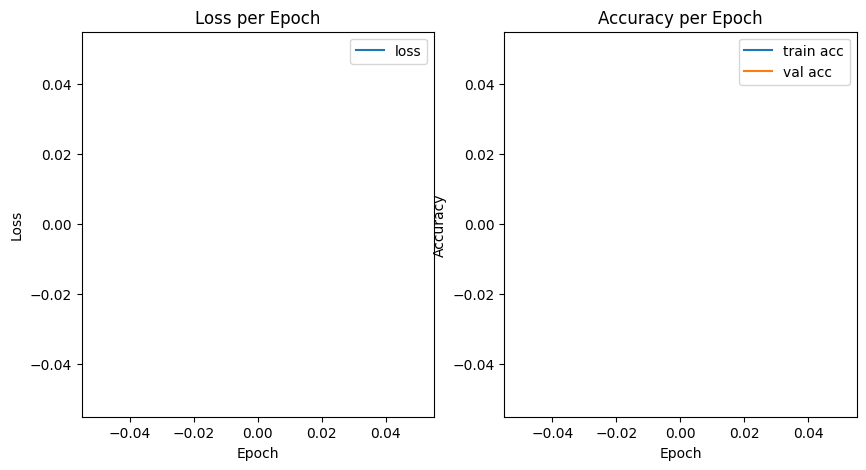

In [201]:
plt.figure(figsize=(10, 5))

trained_epochs = len(train_loss) // len(training_dataloader)
avg_train_loss = average_chunkwise(train_loss, len(training_dataloader), trained_epochs)
avg_train_acc = average_chunkwise(train_acc, len(training_dataloader), trained_epochs)
avg_val_acc = average_chunkwise(val_acc, len(validation_dataloader), trained_epochs)

plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label="loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label="train acc")
plt.plot(avg_val_acc, label="val acc")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [202]:
model = model.cpu()
with open('model_state.pt', 'wb') as f: 
        save(model.state_dict(), f)
model = model.to(device)

In [ ]:
with open('model_state.pt', 'rb') as f: 
        model.load_state_dict(load(f))  